# Building a network

The purpose of this notebook is to create a network to control an effector, and to train it to perform a task through the optimization process. We will also briefly cover how to save and re-load a network.

For how to build an effector and environment from scratch, feel free to look up the `1-build-effector.ipynb` and `3-environments.ipynb` notebooks.

Let's start by importing what we need.


In [1]:
import os
import sys
import json
import numpy as np
import torch as th
import matplotlib.pyplot as plt

motornet_in_cwd = os.path.exists("MotorNet") or os.path.exists("motornet")
colab_env = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'__IPYTHON__') else False
colab_initialized = True if motornet_in_cwd else False

if colab_env and not colab_initialized:
  !pip install gymnasium>=2.8
  !pip install git+https://github.com/OlivierCodol/MotorNet@pytorch
  sys.path.append('MotorNet')
  print("Running cell using COLAB initialization...")
elif colab_env and colab_initialized:
  print("Already initialized using COLAB initialization.")
else:
  paths = [p for p in sys.path if os.path.exists(p)]
  local_initialized = True if [p for p in paths if "MotorNet" in os.listdir(p)] else False
  if local_initialized:
    %load_ext autoreload
    %autoreload 2
    print("Already initialized using LOCAL initialization.")
  else:
    path = [p for p in paths if p.__contains__("examples")]
    if len(path) != 1:
      raise ValueError("Path to MotorNet could not be determined with certainty.")
    else:
      path = path[0]
    sys.path.append(os.path.dirname(path[:path.rfind('examples')]))
    %load_ext autoreload
    %autoreload 2
    print("Running cell using LOCAL initialization...")


import motornet as mn


print('All packages imported.')
print('pytorch version: ' + th.__version__)
print('numpy version: ' + np.__version__)
print('motornet version: ' + mn.__version__)



Running cell using LOCAL initialization...
All packages imported.
pytorch version: 2.0.1
numpy version: 1.23.0
motornet version: 0.2.0



# I. Introduction

Since the purpose of this notebook is not to show how to build an effector or an environment, we will use a pre-built effector and environment that comes with the `motornet` toolbox. This is a 4-muscles point mass plant, with `ReluMuscle` actuators, and a simple random-to-random position reaching task.

Generally speaking, the objects we create follow the hierarchical structure illustrated below.




<img src="img/hierarchy.png" alt="drawing" width="500"/>


# II. Building the model

## II. 1. `Effector` and `Environment` instances.
All the elements below take from previous tutorials, so we are just repeating them here.

Note that we specify the maximum duration of an episode to be 1 sec. We set this up explicitly here, but this is actually the default if no value is provided.

In [2]:

effector = mn.effector.ReluPointMass24()
env = mn.environment.RandomTargetReach(effector=effector, max_ep_duration=1.)


## II. 2. Building the network

This step simply reduces to building a `torch.nn.Module` subclass. If you are not sure on how to achieve that, there are many tutorials available online for learning PyTorch basics.

A good and simple model for this kind of task is to have one recurrent layer receiving observation inputs, so the input dimension is the size of the observation vector. Here we specify the recurrent layer to be one layer of 32 Gated Recurrent Units (GRUs). The output layer is a simple fully connected linear layer, with a sigmoid non-linearity.

Note that we initialize the fully connected layer's bias to be `-5`, to ensure we start the training with low output forces and therefore a more stable situation. Also note that the action that should be input into the environment should be bounded from 0 to 1, which the sigmoid guarantees.

In [3]:


class Policy(th.nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int, device):
        super().__init__()
        self.device = device
        self.hidden_dim = hidden_dim
        self.n_layers = 1
        
        self.gru = th.nn.GRU(input_dim, hidden_dim, 1, batch_first=True)
        self.fc = th.nn.Linear(hidden_dim, output_dim)
        self.sigmoid = th.nn.Sigmoid()

        # the default initialization in torch isn't ideal
        for name, param in self.named_parameters():
            if name == "gru.weight_ih_l0":
                th.nn.init.xavier_uniform_(param)
            elif name == "gru.weight_hh_l0":
                th.nn.init.orthogonal_(param)
            elif name == "gru.bias_ih_l0":
                th.nn.init.zeros_(param)
            elif name == "gru.bias_hh_l0":
                th.nn.init.zeros_(param)
            elif name == "fc.weight":
                th.nn.init.xavier_uniform_(param)
            elif name == "fc.bias":
                th.nn.init.constant_(param, -5.)
            else:
                raise ValueError
        
        self.to(device)

    def forward(self, x, h0):
        y, h = self.gru(x[:, None, :], h0)
        u = self.sigmoid(self.fc(y)).squeeze(dim=1)
        return u, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device)
        return hidden
    
device = th.device("cpu")

policy = Policy(env.observation_space.shape[0], 32, env.n_muscles, device=device)
optimizer = th.optim.Adam(policy.parameters(), lr=10**-3)



We can then train the `Policy` network like we would any PyTorch model. The output of the `Policy` is then passed as input to the `Environment` object using the `Environment.step()` method. The `obs` and `info` ouputs are then collected and used for the loss computation and the backward pass.

Importantly, adding some clipping greatly improves the training process for motor tasks in general.

In [4]:

batch_size = 32
n_batch = 6000
losses = []
interval = 250

def l1(x, y):
  """L1 loss"""
  return th.mean(th.sum(th.abs(x - y), dim=-1))

for batch in range(n_batch):
  # initialize batch
  h = policy.init_hidden(batch_size=batch_size)
  obs, info = env.reset(batch_size=batch_size)
  terminated = False

  # initial positions and targets
  xy = [info["states"]["fingertip"][:, None, :]]
  tg = [info["goal"][:, None, :]]

  # simulate whole episode
  while not terminated:  # will run until `max_ep_duration` is reached
    action, h = policy(obs, h)
    obs, reward, terminated, truncated, info = env.step(action=action)

    xy.append(info["states"]["fingertip"][:, None, :])  # trajectories
    tg.append(info["goal"][:, None, :])  # targets

  # concatenate into a (batch_size, n_timesteps, xy) tensor
  xy = th.cat(xy, axis=1)
  tg = th.cat(tg, axis=1)
  loss = l1(xy, tg)  # L1 loss on position
  
  # backward pass & update weights
  loss.backward()
  th.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=1.)  # important!
  optimizer.step()
  losses.append(loss.item())

  if (batch % interval == 0) and (batch != 0):
    print("Batch {}/{} Done, mean policy loss: {}".format(batch, n_batch, sum(losses[-interval:])/interval))



Batch 250/6000 Done, mean policy loss: 0.659262159705162
Batch 500/6000 Done, mean policy loss: 0.289030639231205
Batch 750/6000 Done, mean policy loss: 0.23719243597984313
Batch 1000/6000 Done, mean policy loss: 0.20436438816785812
Batch 1250/6000 Done, mean policy loss: 0.18742166256904602
Batch 1500/6000 Done, mean policy loss: 0.17224474912881851
Batch 1750/6000 Done, mean policy loss: 0.1650868456363678
Batch 2000/6000 Done, mean policy loss: 0.15629603505134582
Batch 2250/6000 Done, mean policy loss: 0.1480227920114994
Batch 2500/6000 Done, mean policy loss: 0.1443774273991585
Batch 2750/6000 Done, mean policy loss: 0.1380026542544365
Batch 3000/6000 Done, mean policy loss: 0.13354872393608094
Batch 3250/6000 Done, mean policy loss: 0.13061015650629998
Batch 3500/6000 Done, mean policy loss: 0.12857805880904197
Batch 3750/6000 Done, mean policy loss: 0.12725698912143707
Batch 4000/6000 Done, mean policy loss: 0.1256080215871334
Batch 4250/6000 Done, mean policy loss: 0.1232933634

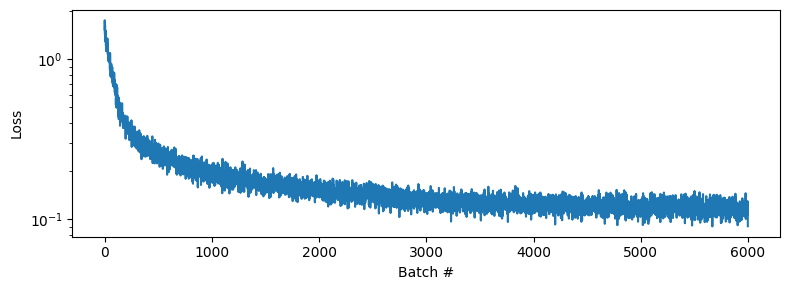

In [5]:
def plot_training_log(log):
  fig, axs = plt.subplots(1, 1)
  fig.set_tight_layout(True)
  fig.set_size_inches((8, 3))

  axs.semilogy(log)

  axs.set_ylabel("Loss")
  axs.set_xlabel("Batch #")
  plt.show()

plot_training_log(losses)

# III. Evaluating performance

A forward pass on the model (with `deterministic=True`) will yield the evaluation behaviour.

We can plot the resulting states to quickly visualize what the network is doing.


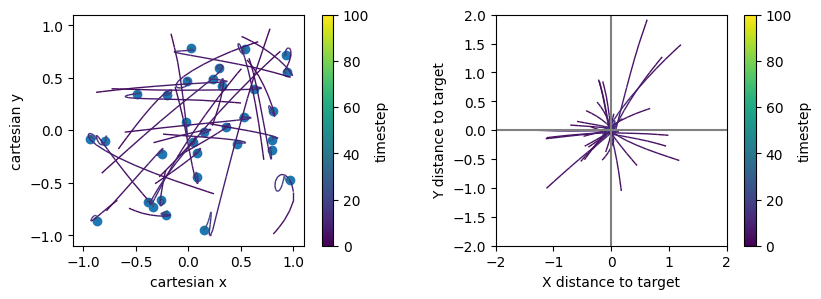

In [6]:
plotor = mn.plotor.plot_pos_over_time

def plot_simulations(xy, target_xy):
  target_x = target_xy[:, -1, 0]
  target_y = target_xy[:, -1, 1]

  plt.figure(figsize=(10,3))

  plt.subplot(1,2,1)
  plt.ylim([-1.1, 1.1])
  plt.xlim([-1.1, 1.1])
  plotor(axis=plt.gca(), cart_results=xy)
  plt.scatter(target_x, target_y)

  plt.subplot(1,2,2)
  plt.ylim([-2, 2])
  plt.xlim([-2, 2])
  plotor(axis=plt.gca(), cart_results=xy - target_xy)
  plt.axhline(0, c="grey")
  plt.axvline(0, c="grey")
  plt.xlabel("X distance to target")
  plt.ylabel("Y distance to target")
  plt.show()


plot_simulations(xy=th.detach(xy), target_xy=th.detach(tg))


# IV. Saving the model

Next, we can save the network like we would any PyTorch model. We will also save the training history as a `.json` file, and the environment's configuration information for later reference.


In [7]:

weight_file = os.path.join("save", "weights")
log_file = os.path.join("save", "log.json")
cfg_file = os.path.join("save", "cfg.json")


# save model weights
th.save(policy.state_dict(), weight_file)


# save training history (log)
with open(log_file, 'w') as file:
    json.dump(losses, file)


# save environment configuration dictionary
cfg = env.get_save_config()
with open(cfg_file, 'w') as file:
    json.dump(cfg, file)


print("done.")


done.



# V. Loading the model

## V. 1. The configuration file
This file is what the `Environment.get_save_config()` method produces. It contains a dictionary with all the parameter and configuration values used to create the environment. Let's look into its structure quickly.


In [8]:


with open(cfg_file, 'r') as file:
    cfg = json.load(file)


for k1, v1 in cfg.items():
  if isinstance(v1, dict):
    print(k1 + ":")
    for k2, v2 in v1.items():
      if type(v2) is dict:
        print("\t\t" + k2 + ":")
        for k3, v3 in v2.items():
          print("\t\t\t\t" + k3 + ": ", v3)
      else:
        print("\t\t" + k2 + ": ", v2)
  else:
    print(k1 + ": ", v1)


name:  Env
action_frame_stacking:  0
action_noise:  [0.0, 0.0, 0.0, 0.0]
delay_range:  [0, 0]
differentiable:  True
dt:  0.01
elapsed:  1.0000000000000007
max_ep_duration:  1.0
metadata:
		render_modes:  []
n_muscles:  4
nq_init:  None
obs_noise:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
proprioception_delay:  1
proprioception_noise:  [0.0]
q_init:  None
render_mode:  None
reward_range:  [-inf, inf]
space_dim:  2
spec:  None
vision_delay:  1
vision_noise:  [0.0]
effector:
		muscle:
				name:  ReluMuscle
				state names:  ['activation', 'muscle length', 'muscle velocity', 'force']
		skeleton:
				dof:  2
				dt:  0.01
				space_dim:  2
				mass:  1
		dt:  0.01
		n_ministeps:  1
		minidt:  0.01
		half_minidt:  0.005
		muscle_names:  ['UpperRight', 'UpperLeft', 'LowerRight', 'LowerLeft']
		n_muscles:  4
		proprioceptive_delay:  1
		visual_delay:  1
		muscle_wrapping_cfg:
				UpperRight:  {'n_fixation_points': 2, 'fixation body': [0, 1], 'coordinates': [[2.0, 2.0], [0.0


## V. 2. Training history

We can use the `.json` file containing the training history to retrieve and plot losses over time.

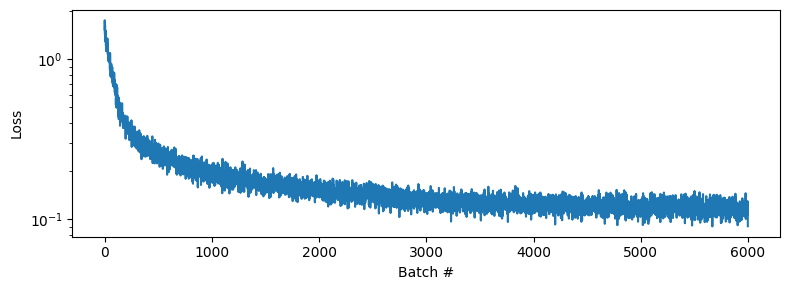

In [9]:
# retrieve and plot training history
with open(log_file, 'r') as file:
    loaded_training_log = json.load(file)

plot_training_log(log=loaded_training_log)




## V. 3. The model itself

Usually, reloading the model would involve re-creating the same model, and applying the trained weights to that model again. To re-create the model, one could re-use the same function as was used to create the original model (that's what we will do here), or one could exploit the configuration file we saved and re-loaded above to recreate a model exhaustively. The latter method might be more tedious to implement but has the benefit of being more exhaustive on the long run.


In [10]:

env2 = mn.environment.RandomTargetReach(effector=mn.effector.ReluPointMass24(), max_ep_duration=1.)
policy2 = Policy(env.observation_space.shape[0], 32, env.n_muscles, device=device)

policy2.load_state_dict(th.load(weight_file))


<All keys matched successfully>


# VI. Evaluating the loaded model

We can then do a forward pass the loaded model like we did on the original model.



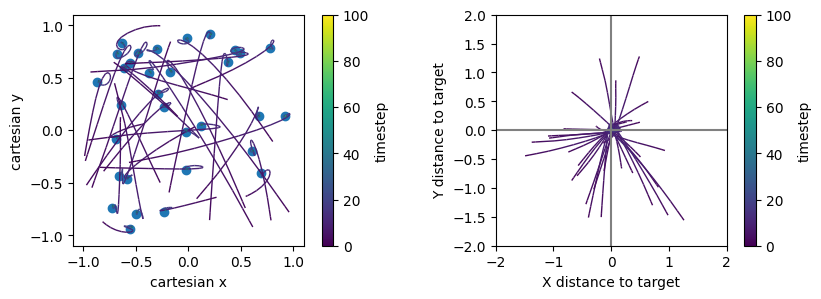

In [11]:
# ==========
# Evaluation
# ==========

# initialize batch
h = policy.init_hidden(batch_size=batch_size)
obs, info = env.reset(batch_size=batch_size)
terminated = False

# initial positions and targets
xy = [info["states"]["fingertip"][:, None, :]]
tg = [info["goal"][:, None, :]]

# simulate whole episode
while not terminated:  # will run until `max_ep_duration` is reached
  action, h = policy(obs, h)
  obs, reward, terminated, truncated, info = env.step(action=action)

  xy.append(info["states"]["fingertip"][:, None, :])  # trajectories
  tg.append(info["goal"][:, None, :])  # targets

# concatenate into a (batch_size, n_timesteps, xy) tensor
xy = th.detach(th.cat(xy, axis=1))
tg = th.detach(th.cat(tg, axis=1))

plot_simulations(xy=xy, target_xy=tg)
